In [1]:
import numpy as np
import scipy.integrate as integrate
from numpy.linalg import inv
import math as m
from functions import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import importlib
from fpdf import FPDF

%load_ext autoreload

%autoreload 2

np.set_printoptions(suppress=True)

This next block will create a class for all of our inputs to be placed into. This will allow for all inputs to have easily accessed names, values, and units.

In [2]:
class Input:
    def __init__(self, name, value, unit):
        self.name = name
        self.value = value
        #self.valueType = type(value)
        self.unit = unit
    
    def print_values(self):
        print("\n")
        for attr, value in self.__dict__.items():
            print(f"{attr}: {value}")

# Please fill in all inputs and their units below
# v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v 

# Constants
<br>For Reference: Units Set: Pa, N, m4, m

In [3]:
YOUNGSMODULUS = 200 * (10**9)
YM_UNIT = "Pa"

MOI = 8 * (10**(-8))
MOI_UNIT = "m4"

W3 = 55 
dist_load_length = 3.2 #length that the distributed load acts upon in the corresponding units to W3
load_direction = -1 #negative 1 if distributed load points down, +1 otherwise
FORCE_UNIT = "N"

nArray = np.array([[1,2], [2,3], [3,4], [4,5]])
print(f"number of elements: {len(nArray)}")

coords = np.array([[0,0], [1.6,0], [(1.6 + (3.2/3)), 0], [(1.6 + 2*(3.2/3)), 0], [4.8,0]])
print(coords)

LENGTHS_UNIT = "m"

problem_number = 302

homework_number = 6




number of elements: 4
[[0.         0.        ]
 [1.6        0.        ]
 [2.66666667 0.        ]
 [3.73333333 0.        ]
 [4.8        0.        ]]


# Boundary Conditions
#### for v & phi: [node#, v, phi] -> v and phi are assumed to be unknown (None) -> only input if known
#### for forces: [node#, Fy, moment] -> forces and moments are assumed to be 0 -> only input if not 0

<br>Please note, node# are inputted straight from the diagram - do not adjust for python counting

In [4]:
v_phi_bcs = np.array([[1, 0, None],[5, 0, None]])

forceMoment_BCs = np.array([[1, None, 40], [5, None, 0]])

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Create our final output pdf

In [5]:
filename = f'HW{homework_number} Problem {problem_number} Numerical Outputs.txt'
f = open(filename, 'w')

f = open(filename, 'a')
f.write(f"Numerical Outputs for HW{str(homework_number)} Problem {str(problem_number)}\n\n")

39

In [6]:
E = Input("Young's Modulus", YOUNGSMODULUS, YM_UNIT)
E.print_values()

I_ = Input("Moment of Inertia", MOI, MOI_UNIT)
I_.print_values()

nodes = Input("Node numbers", nArray, "None")
nodes.print_values()

nodeCoordinates = Input("Node Coordinates (x, y)", coords, LENGTHS_UNIT)
nodeCoordinates.print_values()

total_length = np.max(nodeCoordinates.value)
print(f"total length: {total_length}")





name: Young's Modulus
value: 200000000000
unit: Pa


name: Moment of Inertia
value: 8e-08
unit: m4


name: Node numbers
value: [[1 2]
 [2 3]
 [3 4]
 [4 5]]
unit: None


name: Node Coordinates (x, y)
value: [[0.         0.        ]
 [1.6        0.        ]
 [2.66666667 0.        ]
 [3.73333333 0.        ]
 [4.8        0.        ]]
unit: m
total length: 4.8


number of elements is the number of rows in nodes
<br>number of nodes is the maximum number found in nodes

In [7]:
count_elems = len(nodes.value)
print(f"number of elements: {count_elems}")

count_nodes = nodes.value.max()
print(f"number of nodes: {count_nodes}")

dimension = (2*count_nodes)
print(f"dimension = {dimension}")

number of elements: 4
number of nodes: 5
dimension = 10


In [8]:
LENGTHS = np.zeros(count_elems)
print(LENGTHS)

for i in range(count_elems):

    connection = nodes.value[i]
    N1 = connection[0]
    N2 = connection[1]

    x1 = (nodeCoordinates.value[N1-1])[0]
    y1 = (nodeCoordinates.value[N1-1])[1]

    x2 = (nodeCoordinates.value[N2-1])[0]
    y2 = (nodeCoordinates.value[N2-1])[1]

    LENGTHS[i] = get_element_length(x1, y1, x2, y2)

    print(f"element {i+1}: length = {LENGTHS[i]} (raw value)")

print(LENGTHS)

lengths = Input("Lengths", LENGTHS, LENGTHS_UNIT)
lengths.print_values()


[0. 0. 0. 0.]
element 1: length = 1.6 (raw value)
element 2: length = 1.0666666666666669 (raw value)
element 3: length = 1.0666666666666664 (raw value)
element 4: length = 1.0666666666666664 (raw value)
[1.6        1.06666667 1.06666667 1.06666667]


name: Lengths
value: [1.6        1.06666667 1.06666667 1.06666667]
unit: m


In [9]:
print(sum_until_n(lengths.value, 2))

3.7333333333333334


two reactions per node
<br>v_phi_list -> list of unknowns (node displacements)
<br>we can input our known values -> fixed_nodes at nodes 4 & 5
<br>these fixed nodes numbers are taken straight from diagram (not adjusted for python counting)
<br><br>u and v for any given node is given as (node# - 1)* 2 and ((node# -1)* 2) + 1 respectively.


In [10]:
v_phi_list = [None]*(dimension)
print("displacement bcs: [node number, y disp (v), angle of rotation (phi)]")
print(v_phi_bcs)

adjust_array(v_phi_list, v_phi_bcs, "displacements")

print("v & phi list:")
print(v_phi_list)

displacement bcs: [node number, y disp (v), angle of rotation (phi)]
[[1 0 None]
 [5 0 None]]
adjusting array to account for: displacements boundary conditions
case 1 for BC 1
case 4 for BC 1
case 1 for BC 2
case 4 for BC 2
done adjusting displacements array!
v & phi list:
[0, None, None, None, None, None, None, None, 0, None]


Same procedure as displacement BCs for forces
<br>Input BCs given as : [node #, x force, y force]

In [11]:
force_list = [0]*dimension
#force_list = np.zeros(((count_nodes*2), 1))

nodesWithLoads = []

loadedNodes = 0

for i in range(len(forceMoment_BCs)):
    if forceMoment_BCs[i,1] != None or forceMoment_BCs[i,2] != None:
        loadedNodes += 1
        nodesWithLoads.append((forceMoment_BCs[i,0] - 1))

for i in range(len(v_phi_list)):
    if v_phi_list[i] == 0:
        force_list[i] = None
    elif v_phi_list[i] is None:
        force_list[i] = 0

#adjust force array given concentrated loading conditions
adjust_array(force_list, forceMoment_BCs, "forces")

print(f"number of nodes with concentrated loads: {loadedNodes}")
print(f"at nodes: {nodesWithLoads}")

print(f"force list: \n{force_list}")

adjusting array to account for: forces boundary conditions
case 3 for BC 1
Case 2 for BC 1
case 3 for BC 2
case 4 for BC 2
done adjusting forces array!
number of nodes with concentrated loads: 2
at nodes: [0, 4]
force list: 
[None, 40, 0, 0, 0, 0, 0, 0, None, 0]


In [12]:
if W3 != 0:
    m_constant = W3
    print(f"slope = {m_constant}")
    loose_ft = [0] * (count_elems * 4)

    fw = [0] * dimension
    #for each element, create local fw and transport to global
    for i in range(count_elems):
        if i != 0:
            #b_constant = 0 if i == 0 else lengths.value[i-1] * m_constant
            #print(f"for element {i+1}: b constant: {b_constant}")

            tStar1 = lambda x: (create_NT(x, lengths.value[i]))[0,0] * load_direction * (m_constant)
            tStar2 = lambda x: (create_NT(x, lengths.value[i]))[0,1] * load_direction * (m_constant)
            tStar3 = lambda x: (create_NT(x, lengths.value[i]))[0,2] * load_direction * (m_constant)
            tStar4 = lambda x: (create_NT(x, lengths.value[i]))[0,3] * load_direction * (m_constant)  

            ft1, error = integrate.quad(tStar1, 0, lengths.value[i])
            ft2, error = integrate.quad(tStar2, 0, lengths.value[i])
            ft3, error = integrate.quad(tStar3, 0, lengths.value[i])
            ft4, error = integrate.quad(tStar4, 0, lengths.value[i]) 

            fw[2*i] += ft1
            fw[(2*i) + 1] += ft2
            fw[(2*i) + 2] += ft3
            fw[(2*i) + 3] += ft4

            loose_ft[(4*i)] = ft1
            loose_ft[(4*i) + 1] = ft2
            loose_ft[(4*i) + 2] = ft3
            loose_ft[(4*i) + 3] = ft4

            print(f"ft1 = {ft1}, ft2 = {ft2}, ft3 = {ft3}, ft4 = {ft4}")
    print(f"loose ft = {loose_ft}, length = {len(loose_ft)}")
else: 
    fw = 0

print(f"fw = {fw}")


slope = 55
ft1 = -29.33333333333334, ft2 = -5.214814814814816, ft3 = -29.33333333333334, ft4 = 5.214814814814816
ft1 = -29.33333333333333, ft2 = -5.214814814814807, ft3 = -29.333333333333336, ft4 = 5.214814814814815
ft1 = -29.33333333333333, ft2 = -5.214814814814807, ft3 = -29.333333333333336, ft4 = 5.214814814814815
loose ft = [0, 0, 0, 0, -29.33333333333334, -5.214814814814816, -29.33333333333334, 5.214814814814816, -29.33333333333333, -5.214814814814807, -29.333333333333336, 5.214814814814815, -29.33333333333333, -5.214814814814807, -29.333333333333336, 5.214814814814815], length = 16
fw = [0, 0, -29.33333333333334, -5.214814814814816, -58.66666666666667, 8.881784197001252e-15, -58.666666666666664, 7.993605777301127e-15, -29.333333333333336, 5.214814814814815]


Global [k] matrix is a symmetric array of shape (count_nodes x 2, count_nodes x 2)
<br>beam constants are one per element, stored in a numElemes * 1 array.

In [13]:
global_K = np.zeros((dimension, dimension))
print(f"Global K array dimensions: {global_K.shape}")

beam_constant = np.zeros((count_elems,1))
for i in range(count_elems):
    print(f"E = {E.value}, I = {I_.value}, length for element {i+1} = {lengths.value[i]}")
    beam_constant[i] = (E.value*I_.value)/(lengths.value[i]**3)

print(f"beam constants = \n{beam_constant}")

Global K array dimensions: (10, 10)
E = 200000000000, I = 8e-08, length for element 1 = 1.6
E = 200000000000, I = 8e-08, length for element 2 = 1.0666666666666669
E = 200000000000, I = 8e-08, length for element 3 = 1.0666666666666664
E = 200000000000, I = 8e-08, length for element 4 = 1.0666666666666664
beam constants = 
[[ 3906.25   ]
 [13183.59375]
 [13183.59375]
 [13183.59375]]


## Creating the finite element equation for each Truss Element
### Combining into the global K array

In [14]:
for i in range(count_elems):
    local_K = create_beam_local_k(lengths.value[i])
    local_K *= beam_constant[i]
    print(f"\nk matrix for element {i+1}: \n{local_K}")
    #print(local_K)
    start_node = nodes.value[i,0]
    end_node = nodes.value[i,1]
    print(f"Element {i+1} starting at node: {start_node} and ending at node: {end_node}")
    #print(np.vsplit(local_K, 2))
    Sn = (start_node - 1)*2
    En = (end_node - 1)*2
    #first, adjust 0,0 -> then, 2,0; 0,2; and 2,2
    block_array_adjust(Sn, Sn, global_K, 0, 0, local_K)
    block_array_adjust(En, Sn, global_K, 2, 0, local_K)
    block_array_adjust(Sn, En, global_K, 0, 2, local_K)
    block_array_adjust(En, En, global_K, 2, 2, local_K)

print(f"\nGlobal K matrix: \n{global_K}")
unmodified_global_K = global_K.copy()
check_symmetric(global_K)


k matrix for element 1: 
[[ 46875.  37500. -46875.  37500.]
 [ 37500.  40000. -37500.  20000.]
 [-46875. -37500.  46875. -37500.]
 [ 37500.  20000. -37500.  40000.]]
Element 1 starting at node: 1 and ending at node: 2

k matrix for element 2: 
[[ 158203.125   84375.    -158203.125   84375.   ]
 [  84375.      60000.     -84375.      30000.   ]
 [-158203.125  -84375.     158203.125  -84375.   ]
 [  84375.      30000.     -84375.      60000.   ]]
Element 2 starting at node: 2 and ending at node: 3

k matrix for element 3: 
[[ 158203.125   84375.    -158203.125   84375.   ]
 [  84375.      60000.     -84375.      30000.   ]
 [-158203.125  -84375.     158203.125  -84375.   ]
 [  84375.      30000.     -84375.      60000.   ]]
Element 3 starting at node: 3 and ending at node: 4

k matrix for element 4: 
[[ 158203.125   84375.    -158203.125   84375.   ]
 [  84375.      60000.     -84375.      30000.   ]
 [-158203.125  -84375.     158203.125  -84375.   ]
 [  84375.      30000.     -84375.  

In [15]:
if W3 != 0:  
    for i in range(len(force_list)):
        if force_list[i] is not None:
            force_list[i] += fw[i]
        else: force_list[i] = fw[i]
print(force_list)

[0, 40, -29.33333333333334, -5.214814814814816, -58.66666666666667, 8.881784197001252e-15, -58.666666666666664, 7.993605777301127e-15, -29.333333333333336, 5.214814814814815]


In [16]:
j = 0
while j < count_nodes*2:
    print(f"{j}")
    #if j in nodesWithLoads:
     #   j+=2
    #first case: displacement BC = 0. In this case, set combined force values to 0, and alter 
    #global_K to reflect the changes.
    if v_phi_list[j] == 0:
        print(f"u = 0 at row: {j}")
        force_list[j] = 0 
        global_K[j] = 0
        global_K[j,j] = 1
        j+=1
    elif v_phi_list[j] is None:
        print(f"none detected at row {j}")
        j+=1
    else: #when we have a known, non-zero displacement boundary condition
        #alter global stiffness to all zeros and one 1, and set force equal to displacement BC
        print(f"row {j} altered")
        print(v_phi_list[j])
        force_list[j] = v_phi_list[j]
        for c in range(count_nodes):
            if (global_K[j,c] > 0) == True:
                global_K[j,c] = 1
            else:
                global_K[j,c] = 0
        j+=1

                
print(global_K)
print(f"modified forces: {force_list}")
#complete_forces = np.add(np.array(force_list), np.array(fw))
#print(complete_forces)

0
u = 0 at row: 0
1
none detected at row 1
2
none detected at row 2
3
none detected at row 3
4
none detected at row 4
5
none detected at row 5
6
none detected at row 6
7
none detected at row 7
8
u = 0 at row: 8
9
none detected at row 9
[[      1.          0.          0.          0.          0.          0.
        0.          0.          0.          0.   ]
 [  37500.      40000.     -37500.      20000.          0.          0.
        0.          0.          0.          0.   ]
 [ -46875.     -37500.     205078.125   46875.    -158203.125   84375.
        0.          0.          0.          0.   ]
 [  37500.      20000.      46875.     100000.     -84375.      30000.
        0.          0.          0.          0.   ]
 [      0.          0.    -158203.125  -84375.     316406.25        0.
  -158203.125   84375.          0.          0.   ]
 [      0.          0.      84375.      30000.          0.     120000.
   -84375.      30000.          0.          0.   ]
 [      0.          0.          

In [17]:
#global_K.round(0)
global_K_inv = inv(global_K)
print(global_K_inv)

node = 1

final_u_phi = np.matmul(global_K_inv, force_list)

for i in range(len(final_u_phi)):
    if check_even(i) == True:
        print(f"u{node} = {final_u_phi[i]} {LENGTHS_UNIT}")
        f.write(f"u{str(node)} = {str(round(final_u_phi[i], 7))} {str(LENGTHS_UNIT)}\n")
    else:
        print(f"phi{node} = {final_u_phi[i]} rad\n")
        f.write(f"phi{str(node)} = {str(round(final_u_phi[i], 7))} rad\n")
        node += 1 

[[ 1.         -0.          0.         -0.         -0.         -0.
  -0.          0.          0.         -0.        ]
 [-0.20833333  0.0001      0.00008889  0.00001667  0.0000856  -0.00002037
   0.0000507  -0.00004259  0.20833333 -0.00005   ]
 [ 0.66666667  0.00008889  0.00011378  0.00003556  0.00011799 -0.0000237
   0.00007164 -0.00005926  0.33333333 -0.00007111]
 [-0.20833333  0.00001667  0.00003556  0.00003333  0.00005004 -0.0000037
   0.00003292 -0.00002593  0.20833333 -0.00003333]
 [ 0.44444444  0.0000856   0.00011799  0.00005004  0.00014047 -0.00001317
   0.0000913  -0.00007243  0.55555556 -0.00009218]
 [-0.20833333 -0.00002037 -0.0000237  -0.0000037  -0.00001317  0.00002593
   0.00000132  0.0000037   0.20833333 -0.0000037 ]
 [ 0.22222222  0.0000507   0.00007164  0.00003292  0.0000913   0.00000132
   0.00006883 -0.00004609  0.77777778 -0.00007374]
 [-0.20833333 -0.00004259 -0.00005926 -0.00002593 -0.00007243  0.0000037
  -0.00004609  0.00004815  0.20833333  0.00004074]
 [ 0.      

### Finding forces

In [18]:
elem_forces_moments = [0] * (count_elems*4)
for i in range(count_elems):
    mover = 4*i
    if W3 != 0:
        local_K = create_beam_local_k(lengths.value[i])
        local_K *= beam_constant[i]
        local_U = np.array([
            [final_u_phi[2*i]],
            [final_u_phi[(2*i) + 1]], 
            [final_u_phi[(2*i) + 2]], 
            [final_u_phi[(2*i) + 3]]
        ])
        local_fw = np.array([
            [loose_ft[mover]], 
            [loose_ft[mover + 1]], 
            [loose_ft[mover + 2]], 
            [loose_ft[mover + 3]]
        ])
        local_forces = np.subtract((local_K @ local_U), local_fw)

        #negatives convert to EB sign convention
        #local_forces[1,0] *= -1
        #local_forces[2,0] *= -1

        elem_forces_moments[mover] = local_forces[0,0]
        elem_forces_moments[mover + 1] = local_forces[1,0]
        elem_forces_moments[mover + 2] = local_forces[2,0]
        elem_forces_moments[mover + 3] = local_forces[3,0]

        print(f"local forces (element {i+1}) [{FORCE_UNIT}] = \n{local_forces}")
    else:
        local_K = create_beam_local_k(lengths.value[i])
        local_K *= beam_constant[i]
        local_U = np.array([
            [final_u_phi[2*i]],
            [final_u_phi[(2*i) + 1]], 
            [final_u_phi[(2*i) + 2]], 
            [final_u_phi[(2*i) + 3]]
        ])
        local_forces = local_K @ local_U

        

        elem_forces_moments[mover] = local_forces[0,0]
        elem_forces_moments[mover + 1] = local_forces[1,0]
        elem_forces_moments[mover + 2] = local_forces[2,0]
        elem_forces_moments[mover + 3] = local_forces[3,0]

        print(f"local forces (element {i+1}) [{FORCE_UNIT}] = \n{local_forces}")


print(f"collected element forces [{FORCE_UNIT}] = \n{elem_forces_moments}")
rounded_f_m = [round(element , 4) for element in elem_forces_moments]
f.write(f"\nForces, Moments = \n{rounded_f_m}\n{FORCE_UNIT}, {FORCE_UNIT}*{LENGTHS_UNIT}")


local forces (element 1) [N] = 
[[ 67. ]
 [ 40. ]
 [-67. ]
 [ 67.2]]
local forces (element 2) [N] = 
[[ 67.        ]
 [-67.2       ]
 [ -8.33333333]
 [107.37777778]]
local forces (element 3) [N] = 
[[   8.33333333]
 [-107.37777778]
 [  50.33333333]
 [  84.97777778]]
local forces (element 4) [N] = 
[[-50.33333333]
 [-84.97777778]
 [109.        ]
 [ -0.        ]]
collected element forces [N] = 
[67.00000000000023, 39.999999999999886, -67.00000000000023, 67.20000000000078, 66.99999999999986, -67.20000000000078, -8.333333333333176, 107.37777777777848, 8.333333333332874, -107.37777777777872, 50.33333333333379, 84.97777777777839, -50.33333333333387, -84.97777777777829, 109.00000000000054, -5.684341886080802e-14]


154

## Finding Stresses

### Max transverse shear stress and bending stress magnitudes

In [19]:
elem_forces = [0] * (count_elems * 2)
elem_moments = [0] * (count_elems * 2)

for i in range(len(elem_forces_moments)):
    if check_even(i) == True:
        elem_forces[int(i / 2)] = elem_forces_moments[i]
    else:
        elem_moments[int((i-1) / 2)] = elem_forces_moments[i]

print(f"elem forces (fea sign convention) = \n{elem_forces}")
print(f"elem moments (fea sign convention) = \n{elem_moments}")

abs_forces = [abs(element) for element in elem_forces]
abs_moments = [abs(element) for element in elem_moments]

max_force = max(abs_forces)
max_moment = max(abs_moments)

print(f"max force = {max_force}, max moment = {max_moment}")

radius = get_radius_from_I(I_.value)
max_trans_shear = (4*max_force)/(3*((m.pi)*(radius**2)))
print(f"\nmaximum transverse shear stress = {max_trans_shear} {YM_UNIT}")
f.write(f"\n\nMaximum transverse shear stress = {str(round(max_trans_shear, 4))} {YM_UNIT}")

max_bending_stress = (max_moment * radius)/(I_.value)
print(f"\nmaximum bending stress = {max_bending_stress} {YM_UNIT}")
f.write(f"\n\nMaximum bending stress = {str(round(max_bending_stress, 4))} {YM_UNIT}")

elem forces (fea sign convention) = 
[67.00000000000023, -67.00000000000023, 66.99999999999986, -8.333333333333176, 8.333333333332874, 50.33333333333379, -50.33333333333387, 109.00000000000054]
elem moments (fea sign convention) = 
[39.999999999999886, 67.20000000000078, -67.20000000000078, 107.37777777777848, -107.37777777777872, 84.97777777777839, -84.97777777777829, -5.684341886080802e-14]
max force = 109.00000000000054, max moment = 107.37777777777872

maximum transverse shear stress = 144949.02854585458 Pa

maximum bending stress = 23978634.68487814 Pa


43

y values = [67.0, 67.0, 67.0, 8.3333, 8.3333, -50.3333, -50.3333, -109.0]
0
1
2
3
x values = [0.0, 1.6, 1.6, 2.666666666666667, 2.666666666666667, 3.7333333333333334, 3.7333333333333334, 4.8]


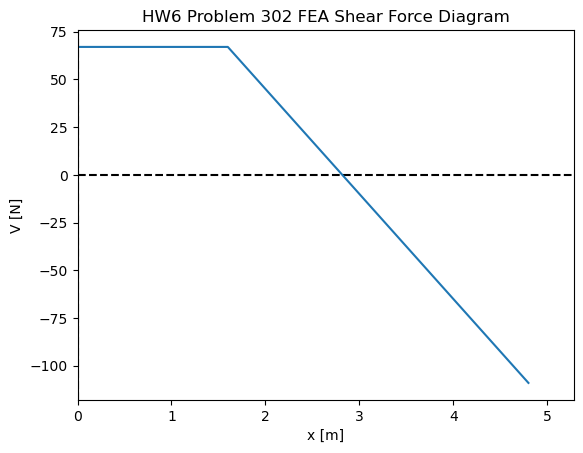

In [20]:
for i in range(len(elem_forces)):
    if check_even(i) == False:
        elem_forces[i] *= -1

shear_y_values = elem_forces
shear_y_values = [round(elem, 4) for elem in shear_y_values]
#shear_y_values.append(0)
print(f"y values = {shear_y_values}")

x_values = [0] * len(elem_forces)

for i in range(count_elems):
    print(i)
    x_values[2*i] += nodeCoordinates.value[i][0]
    x_values[(2*i) + 1] += nodeCoordinates.value[i+1][0]

#x_values.append(x_values[len(elem_forces) - 1])

print(f"x values = {x_values}")

shear_fig = plt.figure("Shear Figure")

plt.title(f"HW{homework_number} Problem {problem_number} FEA Shear Force Diagram")
plt.xlim(0, total_length * 1.1)
plt.axhline(0, color="black", linestyle = "--")
plt.axvline(0, color="black", linestyle = "--")
plt.ylabel(f"V [{FORCE_UNIT}]")
plt.xlabel(f"x [{LENGTHS_UNIT}]")
plt.plot(x_values, shear_y_values)

shear_fig.savefig(f"HW{homework_number} Problem {problem_number} Shear Figure")

plt.show()






y values = [-40.0, 67.2, 67.2, 107.3778, 107.3778, 84.9778, 84.9778, -0.0]
x values = [0.0, 1.6, 1.6, 2.666666666666667, 2.666666666666667, 3.7333333333333334, 3.7333333333333334, 4.8]


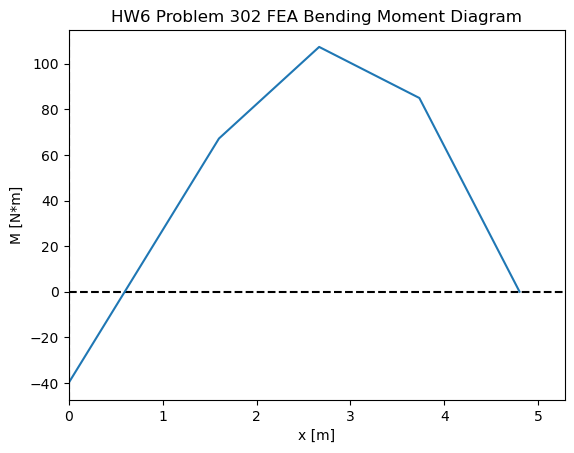

In [21]:
for i in range(len(elem_moments)):
    if check_even(i) == True:
        elem_moments[i] *= -1

moment_y_values = elem_moments
moment_y_values = [round(elem, 4) for elem in moment_y_values]
#moment_y_values.append(0)
print(f"y values = {moment_y_values}")

print(f"x values = {x_values}")

moment_fig = plt.figure("Moment Figure")

plt.title(f"HW{homework_number} Problem {problem_number} FEA Bending Moment Diagram")
plt.xlim(0, total_length * 1.1)
plt.axhline(0, color="black", linestyle = "--")
plt.axvline(0, color="black", linestyle = "--")
plt.ylabel(f"M [{FORCE_UNIT}*{LENGTHS_UNIT}]")
plt.xlabel(f"x [{LENGTHS_UNIT}]")
plt.plot(x_values, moment_y_values)

moment_fig.savefig(f"HW{homework_number} Problem {problem_number} Moment Figure")

plt.show()





0.0 1.6
1.6 2.666666666666667
2.666666666666667 3.7333333333333334
3.7333333333333334 4.8


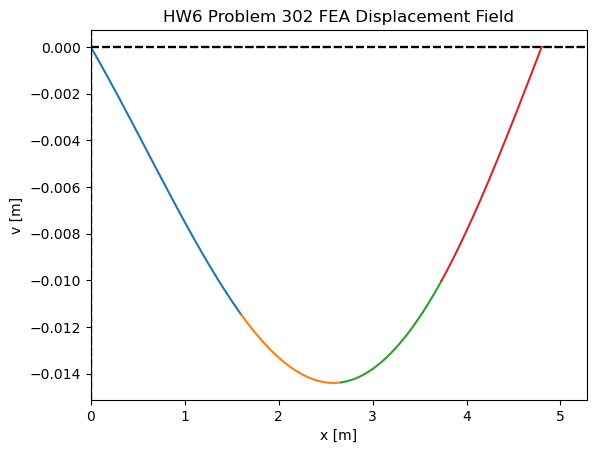

In [22]:
displacement_fig = plt.figure("Displacement Field")

for i in range(count_elems):
    disp_x_values = np.linspace(nodeCoordinates.value[i][0], nodeCoordinates.value[i+1][0], 200)
    print(disp_x_values[0], disp_x_values[199])
    
    def y(x): 
        return (
            create_NT(x - nodeCoordinates.value[i][0], lengths.value[i])[0,0] * final_u_phi[2 * i]
            + create_NT(x - nodeCoordinates.value[i][0], lengths.value[i])[0,1] * final_u_phi[(2 * i) + 1]
            + create_NT(x - nodeCoordinates.value[i][0], lengths.value[i])[0,2] * final_u_phi[(2 * i) + 2]
            + create_NT(x - nodeCoordinates.value[i][0], lengths.value[i])[0,3] * final_u_phi[(2 * i) + 3]
        )   
    
    disp_y_values = list(map(y, disp_x_values))

    #plot labels
    plt.title(f"HW{homework_number} Problem {problem_number} FEA Displacement Field")
    plt.xlim(0, total_length * 1.1)
    plt.axhline(0, color="black", linestyle = "--")
    plt.axvline(0, color="black", linestyle = "--")
    plt.ylabel(f"v [{LENGTHS_UNIT}]")
    plt.xlabel(f"x [{LENGTHS_UNIT}]")

    plt.plot(disp_x_values, disp_y_values)

displacement_fig.savefig(f"HW{homework_number} Problem {problem_number} Displacement Figure")
    
plt.show()
